In [3]:
# Basic exploratory analysis and baseline predictive model

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pathlib import Path

# Show plots inside the notebook
%matplotlib inline

# Path to the cleaned merged weekly dataset
PROJECT_DIR = Path("..")
DATA_PATH = PROJECT_DIR / "datasets" / "clean_data" / "merged_weekly.csv"

print("Merged weekly dataset path:", DATA_PATH.resolve())

# Load the data
df = pd.read_csv(DATA_PATH, parse_dates=["Date"])

# Sort by date just to be safe
df = df.sort_values("Date").reset_index(drop=True)

print("Shape:", df.shape)
df.head()


Merged weekly dataset path: /files/Final Project DSAP/datasets/clean_data/merged_weekly.csv
Shape: (270, 26)


,banking_crisis,bear_market,bull_market,business_confidence,consumer_confidence,debt_crisis,economic_growth,economic_recession,economic_recovery,financial_crisis,...,stock_market_optimism,stock_market_rally,strong_economy,unemployement,Date,SP500,SP500_return_w,SP500_vol_w_4,VIX,VIX_change_w
0,60,3,14,47,34,52,70,29,24,42,...,0,0,44,5,2015-11-06 23:59:59.999999999,2099.199951,0.009496,0.007619,14.33,-0.050351
1,47,4,14,38,28,66,65,31,20,48,...,0,21,44,6,2015-11-13 23:59:59.999999999,2023.040039,-0.036955,0.024985,20.08,0.337369
2,49,3,15,64,28,62,65,31,25,45,...,0,0,36,6,2015-11-20 23:59:59.999999999,2089.169922,0.032165,0.028771,15.47,-0.260822
3,46,2,8,34,26,46,39,17,16,33,...,0,0,24,5,2015-11-27 23:59:59.999999999,2090.110107,0.000450,0.028775,15.12,-0.022884
4,71,3,14,61,26,65,69,27,28,48,...,0,0,41,6,2015-12-04 23:59:59.999999999,2091.689941,0.000756,0.028272,14.81,-0.020716


In [4]:
# Prepare target variable: next week's SP500 return

df = df.copy()

# Current week's return
df["ret_this_week"] = df["SP500_return_w"]

# Next week's return (shifted up: value at t+1)
df["ret_next_week"] = df["SP500_return_w"].shift(-1)

# Drop the last row because ret_next_week is NaN there
df = df.dropna(subset=["ret_next_week"]).reset_index(drop=True)

print("Data after creating ret_next_week:", df.shape)
df[["Date", "ret_this_week", "ret_next_week"]].head()



Data after creating ret_next_week: (269, 28)


,Date,ret_this_week,ret_next_week
0,2015-11-06 23:59:59.999999999,0.009496,-0.036955
1,2015-11-13 23:59:59.999999999,-0.036955,0.032165
2,2015-11-20 23:59:59.999999999,0.032165,0.000450
3,2015-11-27 23:59:59.999999999,0.000450,0.000756
4,2015-12-04 23:59:59.999999999,0.000756,-0.038659


In [5]:
# Train-test split: train = 2015-2018, test = 2019-2020, as Ashley asked

split_date = pd.Timestamp("2019-01-01")

train_df = df[df["Date"] < split_date].copy()
test_df  = df[df["Date"] >= split_date].copy()

print("Train period:", train_df["Date"].min(), "->", train_df["Date"].max())
print("Test  period:", test_df["Date"].min(), "->", test_df["Date"].max())
print("Train shape:", train_df.shape)
print("Test shape :", test_df.shape)


Train period: 2015-11-06 23:59:59.999999999 -> 2018-12-28 23:59:59.999999999
Test  period: 2019-01-04 23:59:59.999999999 -> 2020-12-25 23:59:59.999999999
Train shape: (165, 28)
Test shape : (104, 28)


In [6]:
# List of Google Trends keyword columns
keyword_cols = [
    col for col in df.columns
    if col not in [
        "Date",
        "SP500",
        "SP500_return_w",
        "SP500_vol_w_4",
        "VIX",
        "VIX_change_w",
        "ret_this_week",
        "ret_next_week",
    ]
]

print("Number of keyword series:", len(keyword_cols))
print("Example keywords:", keyword_cols[:5])

# Correlation between each keyword and next week's return (train only)
corrs = (
    train_df[keyword_cols + ["ret_next_week"]]
    .corr()["ret_next_week"]
    .drop("ret_next_week")
    .sort_values(ascending=False)
)

print("Top 10 positive correlations:")
corrs.head(10)


Number of keyword series: 20
Example keywords: ['banking_crisis', 'bear_market', 'bull_market', 'business_confidence', 'consumer_confidence']
Top 10 positive correlations:


stock_market_crash     0.180628
stock_market_rally     0.177585
bear_market            0.142873
bull_market            0.056582
economic_recovery      0.034583
job_creation           0.016590
unemployement          0.004396
recession             -0.004973
debt_crisis           -0.019074
business_confidence   -0.038258
Name: ret_next_week, dtype: float64

In [7]:
print("Top 10 negative correlations:")
corrs.tail(10)


Top 10 negative correlations:


job_losses              -0.040057
economic_recession      -0.050111
consumer_confidence     -0.054780
inflation               -0.056048
economic_growth         -0.060529
strong_economy          -0.079824
banking_crisis          -0.082525
financial_crisis        -0.092875
stock_market_optimism   -0.096624
low_unemployment        -0.155074
Name: ret_next_week, dtype: float64

In [8]:
#Definition positive/negative list keywords

negative_words = [
    "recession",
    "economic_recession",
    "financial_crisis",
    "stock_market_crash",
    "bear_market",
    "inflation",
    "debt_crisis",
    "banking_crisis",
    "job_losses",
    "unemployement"
]
positive_words = [
    "economic_growth",
    "economic_recovery",
    "consumer_confidence",
    "business_confidence",
    "stock_market_rally",
    "bull_market",
    "job_creation",
    "strong_economy",
    "low_unemployment",
    "stock_market_optimism"
]


In [9]:
import pandas as pd
from pathlib import Path

# Path to merged dataset
DATA_PATH = Path("../datasets/clean_data/merged_weekly.csv")

# Load the merged weekly dataset
merged = pd.read_csv(DATA_PATH)

print("Merged dataset loaded:", merged.shape)
merged.head()


Merged dataset loaded: (270, 26)


,banking_crisis,bear_market,bull_market,business_confidence,consumer_confidence,debt_crisis,economic_growth,economic_recession,economic_recovery,financial_crisis,...,stock_market_optimism,stock_market_rally,strong_economy,unemployement,Date,SP500,SP500_return_w,SP500_vol_w_4,VIX,VIX_change_w
0,60,3,14,47,34,52,70,29,24,42,...,0,0,44,5,2015-11-06 23:59:59.999999999,2099.199951,0.009496,0.007619,14.33,-0.050351
1,47,4,14,38,28,66,65,31,20,48,...,0,21,44,6,2015-11-13 23:59:59.999999999,2023.040039,-0.036955,0.024985,20.08,0.337369
2,49,3,15,64,28,62,65,31,25,45,...,0,0,36,6,2015-11-20 23:59:59.999999999,2089.169922,0.032165,0.028771,15.47,-0.260822
3,46,2,8,34,26,46,39,17,16,33,...,0,0,24,5,2015-11-27 23:59:59.999999999,2090.110107,0.000450,0.028775,15.12,-0.022884
4,71,3,14,61,26,65,69,27,28,48,...,0,0,41,6,2015-12-04 23:59:59.999999999,2091.689941,0.000756,0.028272,14.81,-0.020716


In [10]:
#Simple sentiment index 
merged["pos_index"] = merged[positive_words].mean(axis=1)
merged["neg_index"] = merged[negative_words].mean(axis=1)

merged["sentiment_simple"] = merged["pos_index"] - merged["neg_index"]


In [11]:
# Create the target variable: next week's SP500 return
merged["ret_next_week"] = merged["SP500_return_w"].shift(-1)

# Remove the last row (NaN target)
merged = merged.dropna(subset=["ret_next_week"])

print("ret_next_week created successfully:", merged["ret_next_week"].head())


ret_next_week created successfully: 0   -0.036955
1    0.032165
2    0.000450
3    0.000756
4   -0.038659
Name: ret_next_week, dtype: float64


In [12]:
#weighted sentiment index
weights = merged[positive_words + negative_words].corrwith(merged["ret_next_week"])


In [13]:
merged["sentiment_weighted"] = (merged[positive_words + negative_words] * weights).sum(axis=1)
merged["sentiment_weighted"].head()


0   -12.849271
1   -14.872660
2   -14.271036
3    -9.689313
4   -16.421105
Name: sentiment_weighted, dtype: float64

In [21]:
#PCA Sentiment Index
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Extract features
X = merged[positive_words + negative_words]

# Standardize
X_scaled = StandardScaler().fit_transform(X)

# PCA
pca = PCA(n_components=1)
merged["sentiment_pca"] = pca.fit_transform(X_scaled)

print("Variance explained by PC1:", pca.explained_variance_ratio_[0])


Variance explained by PC1: 0.3605534747510498


In [23]:
# Train-test split (after sentiment features are created)
# Ensure Date is a proper datetime before filtering
merged["Date"] = pd.to_datetime(merged["Date"])

split_date = pd.Timestamp("2019-01-01")

train_df = merged.loc[merged["Date"] < split_date].copy()
test_df  = merged.loc[merged["Date"] >= split_date].copy()

print("Train period:", train_df["Date"].min(), "->", train_df["Date"].max())
print("Test period:", test_df["Date"].min(), "->", test_df["Date"].max())


Train period: 2015-11-06 23:59:59.999999999 -> 2018-12-28 23:59:59.999999999
Test period: 2019-01-04 23:59:59.999999999 -> 2020-12-25 23:59:59.999999999


In [26]:

# Feature matrix and target

features = ["sentiment_simple", "sentiment_weighted", "sentiment_pca"]
target = "ret_next_week"

X_train = train_df[features].copy()
y_train = train_df[target].copy()

X_test = test_df[features].copy()
y_test = test_df[target].copy()

print("X_train shape:", X_train.shape, "| X_test shape:", X_test.shape)


X_train shape: (165, 3) | X_test shape: (104, 3)


In [29]:
import statsmodels.api as sm
import numpy as np
import pandas as pd

from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.ensemble import RandomForestRegressor

# OLS (train fit -> test predict)

Xtr = sm.add_constant(X_train)
Xte = sm.add_constant(X_test)

ols_oos = sm.OLS(y_train, Xtr).fit()
y_pred_ols = ols_oos.predict(Xte)

results = [{
    "model": "OLS (OOS)",
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred_ols)),
    "MAE": mean_absolute_error(y_test, y_pred_ols),
    "R2": r2_score(y_test, y_pred_ols)
}]



# ML models

models = {
    "Ridge": Pipeline([
        ("scaler", StandardScaler()),
        ("model", RidgeCV(alphas=np.logspace(-4, 4, 80)))
    ]),
    "Lasso": Pipeline([
        ("scaler", StandardScaler()),
        ("model", LassoCV(alphas=np.logspace(-4, 1, 80), max_iter=30000, random_state=42))
    ]),
    "RandomForest": RandomForestRegressor(n_estimators=600, min_samples_leaf=3, random_state=42)
}

preds = {"OLS (OOS)": y_pred_ols}

for name, model in models.items():
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    preds[name] = y_pred

    results.append({
    "model": name,
    "RMSE": np.sqrt(mean_squared_error(y_test, y_pred)),
    "MAE": mean_absolute_error(y_test, y_pred),
    "R2": r2_score(y_test, y_pred)
})


results_df = pd.DataFrame(results).sort_values("RMSE")
results_df


,model,RMSE,MAE,R2
2,Lasso,0.033184,0.020910,-0.006151
1,Ridge,0.033187,0.020912,-0.006330
3,RandomForest,0.035393,0.022579,-0.144572
0,OLS (OOS),0.036747,0.022845,-0.233838


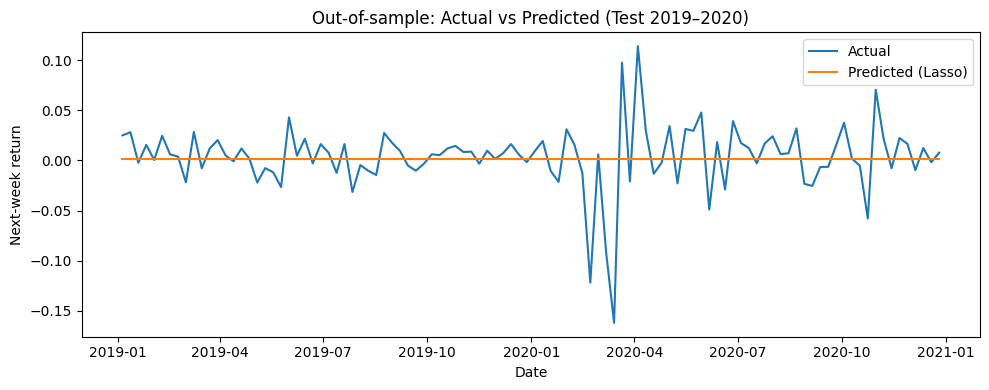

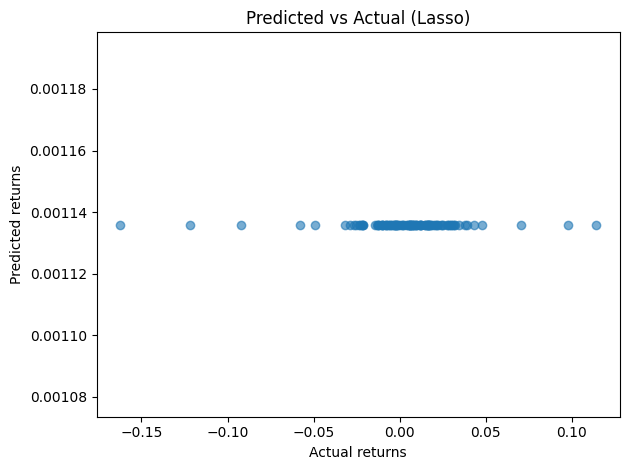

In [34]:
import matplotlib.pyplot as plt
import os

os.makedirs("../outputs", exist_ok=True)

# Pick the best model by RMSE
best_model = results_df.sort_values("RMSE").iloc[0]["model"]
y_best = preds[best_model]

# Time series: actual vs predicted (test)
plot_df = test_df[["Date", "ret_next_week"]].copy()
plot_df["pred_best"] = y_best

plt.figure(figsize=(10, 4))
plt.plot(plot_df["Date"], plot_df["ret_next_week"], label="Actual")
plt.plot(plot_df["Date"], plot_df["pred_best"], label=f"Predicted ({best_model})")
plt.title("Out-of-sample: Actual vs Predicted (Test 2019–2020)")
plt.xlabel("Date")
plt.ylabel("Next-week return")
plt.legend()
plt.tight_layout()
plt.savefig("../outputs/oos_actual_vs_pred.png", dpi=200)
plt.show()

# Scatter: predicted vs actual
plt.figure()
plt.scatter(y_test, y_best, alpha=0.6)
plt.title(f"Predicted vs Actual ({best_model})")
plt.xlabel("Actual returns")
plt.ylabel("Predicted returns")
plt.tight_layout()
plt.savefig("../outputs/oos_scatter.png", dpi=200)
plt.show()



In [31]:
#To choose the best index
indices = ["sentiment_simple", "sentiment_weighted", "sentiment_pca"]

for idx in indices:
    corr = merged[idx].corr(merged["ret_next_week"])
    print(f"{idx} correlation = {corr:.4f}")


sentiment_simple correlation = -0.0392
sentiment_weighted correlation = 0.3162
sentiment_pca correlation = 0.0057


In [32]:
#OLS simple modele predictor 
import statsmodels.api as sm

X = merged[["sentiment_simple", "sentiment_weighted", "sentiment_pca"]]
X = sm.add_constant(X)
y = merged["ret_next_week"]

model = sm.OLS(y, X).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          ret_next_week   R-squared:                       0.106
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     10.47
Date:                Mon, 15 Dec 2025   Prob (F-statistic):           1.56e-06
Time:                        14:57:02   Log-Likelihood:                 622.93
No. Observations:                 269   AIC:                            -1238.
Df Residuals:                     265   BIC:                            -1223.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  0.0124      0